# Import and inspect data

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
import string

In [2]:
!pwd

/Users/keqiaoli/Downloads/complaint-content-classification-nlp-main/notebooks


In [3]:
df = pd.read_csv('complaints_1year.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189158 entries, 0 to 189157
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Date received                 189158 non-null  object 
 1   Product                       189158 non-null  object 
 2   Sub-product                   189158 non-null  object 
 3   Issue                         189158 non-null  object 
 4   Sub-issue                     189158 non-null  object 
 5   Consumer complaint narrative  189158 non-null  object 
 6   Company public response       189158 non-null  object 
 7   Company                       189158 non-null  object 
 8   State                         189158 non-null  object 
 9   ZIP code                      189158 non-null  object 
 10  Tags                          189158 non-null  object 
 11  Consumer consent provided?    189158 non-null  object 
 12  Submitted via                 189158 non-nul

In [5]:
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,12/07/20,Mortgage,Conventional home mortgage,Applying for a mortgage or refinancing an exis...,None,"Caliber Loan Number : XXXX On XX/XX/2020, I sp...",None,"Caliber Home Loans, Inc.",TX,77584,None,Consent provided,Web,12/07/20,Closed with explanation,Yes,NaN,3996455
1,12/23/20,Debt collection,Payday loan debt,Attempts to collect debt not owed,Debt was paid,Mr XXXX from direct recovery service called me...,None,"Direct Recovery Services, LLC",VA,24018,None,Consent provided,Web,12/23/20,Closed with explanation,Yes,NaN,4029017
2,12/05/20,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Old information reappears or never goes away,This closed XXXX XXXX account ( last four XXXX...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,MI,48083,None,Consent provided,Web,12/05/20,Closed with explanation,Yes,NaN,3993040
3,12/24/20,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Investigation took more than 30 days,THESE ACCOUNTS WAS LISTED ON MY CREDIT REPORT ...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,TN,37128,None,Consent provided,Web,12/24/20,Closed with explanation,Yes,NaN,4029947
4,12/24/20,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Investigation took more than 30 days,I reviewed a copy of my credit report and show...,None,"EQUIFAX, INC.",NV,89130,None,Consent provided,Web,12/24/20,Closed with explanation,Yes,NaN,4029968


### Isolate relevant columns

In [6]:
df = df[['Product', 'Sub-product', 'Issue', 'Sub-issue', 'Consumer complaint narrative']]

In [7]:
df = df.rename(columns={"Product": "product", "Sub-product": "subproduct", "Issue": "issue", "Sub-issue": "subissue", "Consumer complaint narrative": "narrative"})

In [8]:
df['product'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    103116
Debt collection                                                                  28593
Credit card or prepaid card                                                      17991
Mortgage                                                                         13884
Checking or savings account                                                      10723
Money transfer, virtual currency, or money service                                6180
Vehicle loan or lease                                                             4171
Payday loan, title loan, or personal loan                                         2321
Student loan                                                                      2179
Name: product, dtype: int64

In [9]:
df['subproduct'].value_counts()

Credit reporting                              101752
General-purpose credit card or charge card     12740
Conventional home mortgage                      8918
Checking account                                8731
Other debt                                      7994
Credit card debt                                6678
I do not know                                   5879
Medical debt                                    4746
Loan                                            3400
Store credit card                               2582
Mobile or digital wallet                        2507
FHA mortgage                                    2232
Domestic (US) money transfer                    1683
Government benefit card                         1651
Federal student loan servicing                  1409
VA mortgage                                     1334
Auto debt                                       1278
Installment loan                                1037
Other personal consumer report                

In [10]:
df['issue'].value_counts()

Incorrect information on your report                                                60140
Problem with a credit reporting company's investigation into an existing problem    35213
Attempts to collect debt not owed                                                   14303
Trouble during payment process                                                       6495
Improper use of your report                                                          6131
                                                                                    ...  
Vehicle was damaged or destroyed the vehicle                                            6
Was approved for a loan, but didn't receive money                                       3
Property was damaged or destroyed property                                              3
Problem with an overdraft                                                               1
Property was sold                                                                       1
Name: issu

In [11]:
df['subissue'].value_counts()

Information belongs to someone else                            36026
None                                                           24176
Their investigation did not fix an error on your report        16225
Account status incorrect                                        8940
Account information incorrect                                   8351
                                                               ...  
Problem with renewal                                               4
Problem with a check written from your prepaid card account        4
Qualified for a better loan than the one offered                   3
Threatened to turn you in to immigration or deport you             3
Problem with fees or penalties                                     2
Name: subissue, Length: 162, dtype: int64

Except for 'product', it doesn't seem there's enough data to train on. Maybe I could do subproduct, too, but I'd want to eliminate those with the lower value counts.

Note for subproduct, a high number is "I don't know." I could maybe classify those. 

In 'subissue', the second highest is 'None'. Also, there seems to be a lot of overlap between the categories, finer points that some consumers may not make. Example: "Debt is not yours" vs. "Debt was result of identity theft".

# Prepare Text

## Inspect first row

In [12]:
print(df.iloc[0])
text = df['narrative'][0]
text

product                                                Mortgage
subproduct                           Conventional home mortgage
issue         Applying for a mortgage or refinancing an exis...
subissue                                                   None
narrative     Caliber Loan Number : XXXX On XX/XX/2020, I sp...
Name: 0, dtype: object


'Caliber Loan Number : XXXX On XX/XX/2020, I spoke with a loan agent by the name of XXXX XXXX about refinancing options and interest rates only. He asked if I wanted to submit a loan application and I explicitly told him, " No \'\'. I filed a complaint with Caliber Homes and no excuse or reason was provided for his unethical actions. Their response was, " Since you decided not to move forward with the loan refinance process, the Loan Consultant was required to withdraw your application in our system. " ( Direct quote ). As if this solves the problem. The issue is, I told him not to submit a loan application in the first place from the beginning. The call was recorded on their end. Caliber is saying that a loan number was required to be opened as part of their inquiry, so that the Loan Consultant could gather my information and be able to provide me the most accurate information available in regards to my refinance options. Even if this were the case, I should have been told that upfron

## Process Data

### Function to tokenize data and remove stopwords

In [13]:
stopwords_list = stopwords.words('english') + list(string.punctuation)
stopwords_list += ["''", '""', '...', '``']

In [14]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/keqiaoli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [16]:
list(string.punctuation)

['!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~']

In [17]:
list('abc')

['a', 'b', 'c']

In [18]:
def process_narrative(narrative):
    tokens = nltk.word_tokenize(narrative)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords_list]
    return stopwords_removed  

### Inspect and process first narrative 

In [19]:
text_words = process_narrative(text)
text_words

['caliber',
 'loan',
 'number',
 'xxxx',
 'xx/xx/2020',
 'spoke',
 'loan',
 'agent',
 'name',
 'xxxx',
 'xxxx',
 'refinancing',
 'options',
 'interest',
 'rates',
 'asked',
 'wanted',
 'submit',
 'loan',
 'application',
 'explicitly',
 'told',
 'filed',
 'complaint',
 'caliber',
 'homes',
 'excuse',
 'reason',
 'provided',
 'unethical',
 'actions',
 'response',
 'since',
 'decided',
 'move',
 'forward',
 'loan',
 'refinance',
 'process',
 'loan',
 'consultant',
 'required',
 'withdraw',
 'application',
 'system.',
 'direct',
 'quote',
 'solves',
 'problem',
 'issue',
 'told',
 'submit',
 'loan',
 'application',
 'first',
 'place',
 'beginning',
 'call',
 'recorded',
 'end',
 'caliber',
 'saying',
 'loan',
 'number',
 'required',
 'opened',
 'part',
 'inquiry',
 'loan',
 'consultant',
 'could',
 'gather',
 'information',
 'able',
 'provide',
 'accurate',
 'information',
 'available',
 'regards',
 'refinance',
 'options',
 'even',
 'case',
 'told',
 'upfront',
 'even',
 'ask',
 'wanted',

In [20]:
# Add to stopwords list

stopwords_list += ['--', 'xxxx', 'xx/xx/2020', 'xx/xx/2021']

In [21]:
# Check out word counts

text_words = process_narrative(text)

word_counts = {}
for i in range(len(text_words)):
    word_counts[text_words[i]] = text_words.count(text_words[i])
word_counts

{'caliber': 3,
 'loan': 10,
 'number': 2,
 'spoke': 1,
 'agent': 1,
 'name': 1,
 'refinancing': 1,
 'options': 2,
 'interest': 1,
 'rates': 1,
 'asked': 1,
 'wanted': 2,
 'submit': 2,
 'application': 5,
 'explicitly': 1,
 'told': 3,
 'filed': 1,
 'complaint': 1,
 'homes': 1,
 'excuse': 1,
 'reason': 1,
 'provided': 1,
 'unethical': 1,
 'actions': 1,
 'response': 1,
 'since': 1,
 'decided': 1,
 'move': 2,
 'forward': 2,
 'refinance': 3,
 'process': 1,
 'consultant': 2,
 'required': 2,
 'withdraw': 1,
 'system.': 1,
 'direct': 1,
 'quote': 1,
 'solves': 1,
 'problem': 1,
 'issue': 1,
 'first': 1,
 'place': 1,
 'beginning': 1,
 'call': 1,
 'recorded': 1,
 'end': 1,
 'saying': 1,
 'opened': 1,
 'part': 1,
 'inquiry': 1,
 'could': 1,
 'gather': 1,
 'information': 3,
 'able': 2,
 'provide': 2,
 'accurate': 1,
 'available': 1,
 'regards': 1,
 'even': 2,
 'case': 1,
 'upfront': 1,
 'ask': 1,
 'submitting': 2,
 'normal/routine': 1,
 'practice': 1,
 'spoken': 1,
 'plenty': 1,
 'companies': 1,
 '

It seems there are a lot of numbers. Update function to get rid of numbers from the list.  

Note: this function also gets rid of strings with punctuation in it like 'xx/xx/xxxx' or "n't".

In [22]:
def process_narrative(narrative):
    tokens = nltk.word_tokenize(narrative)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords_list]
    
    # adding line to remove all tokens with numbers and punctuation
    stopwords_punc_and_numbers_removed = [word for word in stopwords_removed if word.isalpha()]
    
    return stopwords_punc_and_numbers_removed  

In [23]:
# Redoing processing with updated function
text_words = process_narrative(text)

### Make dictionary of word counts

In [24]:
FreqDist(text_words)

FreqDist({'loan': 10, 'application': 5, 'caliber': 3, 'told': 3, 'refinance': 3, 'information': 3, 'number': 2, 'options': 2, 'wanted': 2, 'submit': 2, ...})

In [25]:
type(FreqDist(text_words))

nltk.probability.FreqDist

In [26]:
FreqDist(text_words).most_common(10)

[('loan', 10),
 ('application', 5),
 ('caliber', 3),
 ('told', 3),
 ('refinance', 3),
 ('information', 3),
 ('number', 2),
 ('options', 2),
 ('wanted', 2),
 ('submit', 2)]

Note how calling `most_common()` creates a list of tuples.

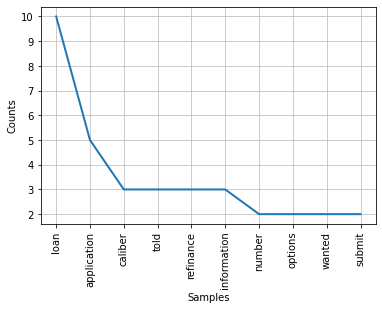

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [27]:
FreqDist(text_words).plot(10)

### Trying process on the next two rows

#### df.iloc[1]

In [28]:
df.iloc[1][0:4]

product                         Debt collection
subproduct                     Payday loan debt
issue         Attempts to collect debt not owed
subissue                          Debt was paid
Name: 1, dtype: object

In [29]:
text = df['narrative'][1]
text

"Mr XXXX from direct recovery service called me about a debt from XXXX  XXXX. When I didn't call them back they called my parents on XX/XX/2020. I called him and got the information from him. His number to call back is XXXX ex XXXX. The reference number is XXXX. He offered me a reduce debt at {$130.00} for the XX/XX/XXXX loan of {$410.00} the loan is from XXXX. I called XXXX XXXX to see if I owed them money and it was paid off XXXX, I owe them nothing and it's a fraud attack from Mr. XXXX and the direct recovery services. Please do what is necessary to stop my harassment."

In [30]:
df

,product,subproduct,issue,subissue,narrative
0,Mortgage,Conventional home mortgage,Applying for a mortgage or refinancing an exis...,None,"Caliber Loan Number : XXXX On XX/XX/2020, I sp..."
1,Debt collection,Payday loan debt,Attempts to collect debt not owed,Debt was paid,Mr XXXX from direct recovery service called me...
2,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Old information reappears or never goes away,This closed XXXX XXXX account ( last four XXXX...
3,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Investigation took more than 30 days,THESE ACCOUNTS WAS LISTED ON MY CREDIT REPORT ...
4,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Investigation took more than 30 days,I reviewed a copy of my credit report and show...
...,...,...,...,...,...
189153,"Money transfer, virtual currency, or money ser...",Domestic (US) money transfer,Fraud or scam,None,This is the messages I have sent to cash app w...
189154,Checking or savings account,Other banking product or service,Problem with a lender or other company chargin...,Money was taken from your account on the wrong...,On XX/XX/21 while in an emergency XXXX- I rece...
189155,"Payday loan, title loan, or personal loan",Title loan,Charged fees or interest you didn't expect,None,I took out a loan back in XXXX of XXXX for {$4...
189156,Debt collection,I do not know,Attempts to collect debt not owed,Debt was result of identity theft,I have a fraudulent account on my credit repor...


In [31]:
text_words = process_narrative(text)

In [32]:
FreqDist(text_words).most_common(30)

[('called', 4),
 ('direct', 2),
 ('recovery', 2),
 ('debt', 2),
 ('call', 2),
 ('back', 2),
 ('number', 2),
 ('loan', 2),
 ('mr', 1),
 ('service', 1),
 ('parents', 1),
 ('got', 1),
 ('information', 1),
 ('ex', 1),
 ('reference', 1),
 ('offered', 1),
 ('reduce', 1),
 ('see', 1),
 ('owed', 1),
 ('money', 1),
 ('paid', 1),
 ('owe', 1),
 ('nothing', 1),
 ('fraud', 1),
 ('attack', 1),
 ('services', 1),
 ('please', 1),
 ('necessary', 1),
 ('stop', 1),
 ('harassment', 1)]

#### df.iloc[2]

In [33]:
df.iloc[2][0:4]

product       Credit reporting, credit repair services, or o...
subproduct                                     Credit reporting
issue                      Incorrect information on your report
subissue           Old information reappears or never goes away
Name: 2, dtype: object

In [34]:
text = df['narrative'][2]
text_words = process_narrative(text)
FreqDist(text_words).most_common(30)

[('closed', 2),
 ('account', 2),
 ('last', 1),
 ('four', 1),
 ('shows', 1),
 ('years', 1),
 ('months', 1),
 ('old', 1),
 ('credit', 1),
 ('removed', 1)]

In [35]:
df.iloc[2]

product       Credit reporting, credit repair services, or o...
subproduct                                     Credit reporting
issue                      Incorrect information on your report
subissue           Old information reappears or never goes away
narrative     This closed XXXX XXXX account ( last four XXXX...
Name: 2, dtype: object

# Combine categories and create new dataframes

## Inspect 

In [36]:
# Inspect products again
df['product'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    103116
Debt collection                                                                  28593
Credit card or prepaid card                                                      17991
Mortgage                                                                         13884
Checking or savings account                                                      10723
Money transfer, virtual currency, or money service                                6180
Vehicle loan or lease                                                             4171
Payday loan, title loan, or personal loan                                         2321
Student loan                                                                      2179
Name: product, dtype: int64

What is "Money transfer, virtual currency, or money service"?

In [43]:
df = df[ (df['product'] != "Debt collection" ) & 
        (df['product'] != "Money transfer, virtual currency, or money service") & 
       (df['product'] != "Checking or savings account")]

In [44]:
df['product'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    103116
Credit card or prepaid card                                                      17991
Mortgage                                                                         13884
Vehicle loan or lease                                                             4171
Payday loan, title loan, or personal loan                                         2321
Student loan                                                                      2179
Name: product, dtype: int64

In [45]:
df[df['product'] == "Money transfer, virtual currency, or money service"].head(10)

,product,subproduct,issue,subissue,narrative


In [46]:
df[df['product'] == "Checking or savings account"].head(10)

,product,subproduct,issue,subissue,narrative


Seems to be about Venmo, digital transactions, international transfers, etc. It's a bit of it's own thing. I'll keep it for now, but there are only 4,602 entries. But I'll fold into "checking and savings" in general, which has only 9,000.

## Combine categories

**Tasks**

- Rename "credit_reporting"  
- Rename "debt_collection"  
- Rename "credit_card"
- Rename "mortgage"
- Combine "checking" and "money transfer" into "retail_banking"
- Combine the loans into "loans"

In [52]:
df['product'].value_counts()

credit_related    121107
loans              22555
Name: product, dtype: int64

In [55]:
df['product'].replace({'Credit reporting, credit repair services, or other personal consumer reports': 'credit_related',
                       'Credit card or prepaid card': 'credit_related',
                       'Mortgage': 'Mortgage and loans',
                       'Vehicle loan or lease': 'Mortgage and loans',
                       'Payday loan, title loan, or personal loan': 'Mortgage and loans',
                       'Student loan': 'Mortgage and loans'}, inplace=True)

In [56]:
df['product'].value_counts()

credit_related    121107
loans              22555
Name: product, dtype: int64

Mortgage and loans are the smallest. Since they're both types of loans, I'll combine them.

In [57]:
df['product'].replace({'mortgage': 'mortgages_and_loans',
                       'loans': 'mortgages_and_loans'}, inplace=True)
df['product'].value_counts()

credit_related         121107
mortgages_and_loans     22555
Name: product, dtype: int64

## Create new dataframes

In [60]:
credit_related_df = df[df['product'] == 'credit_related']
# debt_collection_df = df[df['product'] == 'debt_collection']
mortgages_and_loans_df = df[df['product'] == 'mortgages_and_loans']
# credit_card_df = df[df['product'] == 'credit_card']
# retail_banking_df = df[df['product'] == 'retail_banking']

## Concatenate all the narratives into a single string per class

In [61]:
credit_related_df.head()

,product,subproduct,issue,subissue,narrative
2,credit_related,Credit reporting,Incorrect information on your report,Old information reappears or never goes away,This closed XXXX XXXX account ( last four XXXX...
3,credit_related,Credit reporting,Problem with a credit reporting company's inve...,Investigation took more than 30 days,THESE ACCOUNTS WAS LISTED ON MY CREDIT REPORT ...
4,credit_related,Credit reporting,Problem with a credit reporting company's inve...,Investigation took more than 30 days,I reviewed a copy of my credit report and show...
7,credit_related,Credit reporting,Problem with a credit reporting company's inve...,Investigation took more than 30 days,THESE ACCOUNTS WAS LISTED ON MY CREDIT REPORT ...
11,credit_related,Credit reporting,Problem with a credit reporting company's inve...,Was not notified of investigation status or re...,It would be ideal if you be exhorted that I ha...


In [62]:
def concat_narratives(df):
    # concat narratives
    narr = ''
    for i in range(len(df)):
        narr += df.iloc[i]['narrative']
    print('Finished Concatenation')
    return narr

In [65]:
credit_related_text = concat_narratives(credit_related_df)
credit_related_text_processed = process_narrative(credit_related_text)

Finished Concatenation


In [67]:
# debt_collection_text = concat_narratives(debt_collection_df)
# debt_collection_text_processed = process_narrative(debt_collection_text)

In [68]:
mortgages_and_loans_text = concat_narratives(mortgages_and_loans_df)
mortgages_and_loans_text_processed = process_narrative(mortgages_and_loans_text)

Finished Concatenation


In [69]:
# credit_card_text = concat_narratives(credit_card_df)
# credit_card_text_processed = process_narrative(credit_card_text)

In [70]:
# retail_banking_text = concat_narratives(retail_banking_df)
# retail_banking_text_processed = process_narrative(retail_banking_text)

### Saving the text files

In [71]:
text_file = open('credit_related_text.txt', 'w')
text_file.write(credit_reporting_text)
text_file.close()

In [72]:
# text_file = open('debt_collection_text.txt', 'w')
# text_file.write(debt_collection_text)
# text_file.close()

In [73]:
text_file = open('mortgages_and_loans_text.txt', 'w')
mortgages_and_loans_text = mortgages_and_loans_text.replace('\x82', '')
text_file.write(mortgages_and_loans_text)
text_file.close()

In [74]:
# text_file = open('credit_card_text.txt', 'w')
# text_file.write(credit_card_text)
# text_file.close()

In [75]:
# text_file = open('retail_banking_text.txt', 'w')
# text_file.write(retail_banking_text)
# text_file.close()

### Saving the processed text (lists) files

In [76]:
temp = pd.DataFrame(credit_related_text_processed)
temp.to_csv('credit_related_text_processed.csv')

In [77]:
# temp = pd.DataFrame(debt_collection_text_processed)
# temp.to_csv('debt_collection_text_processed.csv')

In [78]:
temp = pd.DataFrame(mortgages_and_loans_text_processed)
temp.to_csv('mortgages_and_loans_text_processed.csv')

In [79]:
# temp = pd.DataFrame(credit_card_text_processed)
# temp.to_csv('credit_card_text_processed.csv')

In [80]:
# temp = pd.DataFrame(retail_banking_text_processed)
# temp.to_csv('retail_banking_text_processed.csv')

## Check `FreqDist()`

In [81]:
# FreqDist(debt_collection_text_processed).most_common(30)

In [82]:
FreqDist(credit_related_text_processed).most_common(30)

[('credit', 278577),
 ('account', 158581),
 ('report', 138310),
 ('information', 113233),
 ('reporting', 86024),
 ('accounts', 77990),
 ('card', 57660),
 ('consumer', 47539),
 ('dispute', 46923),
 ('payment', 46118),
 ('received', 42389),
 ('days', 40803),
 ('would', 40045),
 ('sent', 39043),
 ('never', 38586),
 ('also', 38197),
 ('please', 37498),
 ('balance', 37289),
 ('identity', 37065),
 ('late', 36596),
 ('company', 34961),
 ('letter', 33847),
 ('time', 33709),
 ('due', 32516),
 ('remove', 32436),
 ('date', 32180),
 ('bureaus', 31157),
 ('file', 30950),
 ('number', 30915),
 ('reported', 30816)]

In [83]:
# FreqDist(credit_card_text_processed).most_common(30)

In [84]:
# FreqDist(retail_banking_text_processed).most_common(30)

In [85]:
FreqDist(mortgages_and_loans_text_processed).most_common(30)

[('loan', 46243),
 ('payment', 35333),
 ('mortgage', 30961),
 ('would', 26980),
 ('account', 21029),
 ('payments', 20665),
 ('told', 18900),
 ('credit', 18410),
 ('received', 17303),
 ('company', 15733),
 ('time', 15524),
 ('called', 14607),
 ('due', 14115),
 ('bank', 13638),
 ('pay', 13154),
 ('get', 13103),
 ('back', 12896),
 ('paid', 12895),
 ('call', 12831),
 ('sent', 12117),
 ('amount', 11849),
 ('made', 10920),
 ('said', 10748),
 ('home', 10690),
 ('never', 10669),
 ('information', 10515),
 ('could', 10115),
 ('one', 9865),
 ('also', 9646),
 ('interest', 9512)]